In [186]:
import json
import urllib
# import urllib2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.image as mpimg
import seaborn as sns

# from mpl_toolkits.basemap import Basemap

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

# _☞ Go to the [bigquery.cloud.google.com/project/rgpkorea-datalake](https://bigquery.cloud.google.com/project/rgpkorea-datalake)_

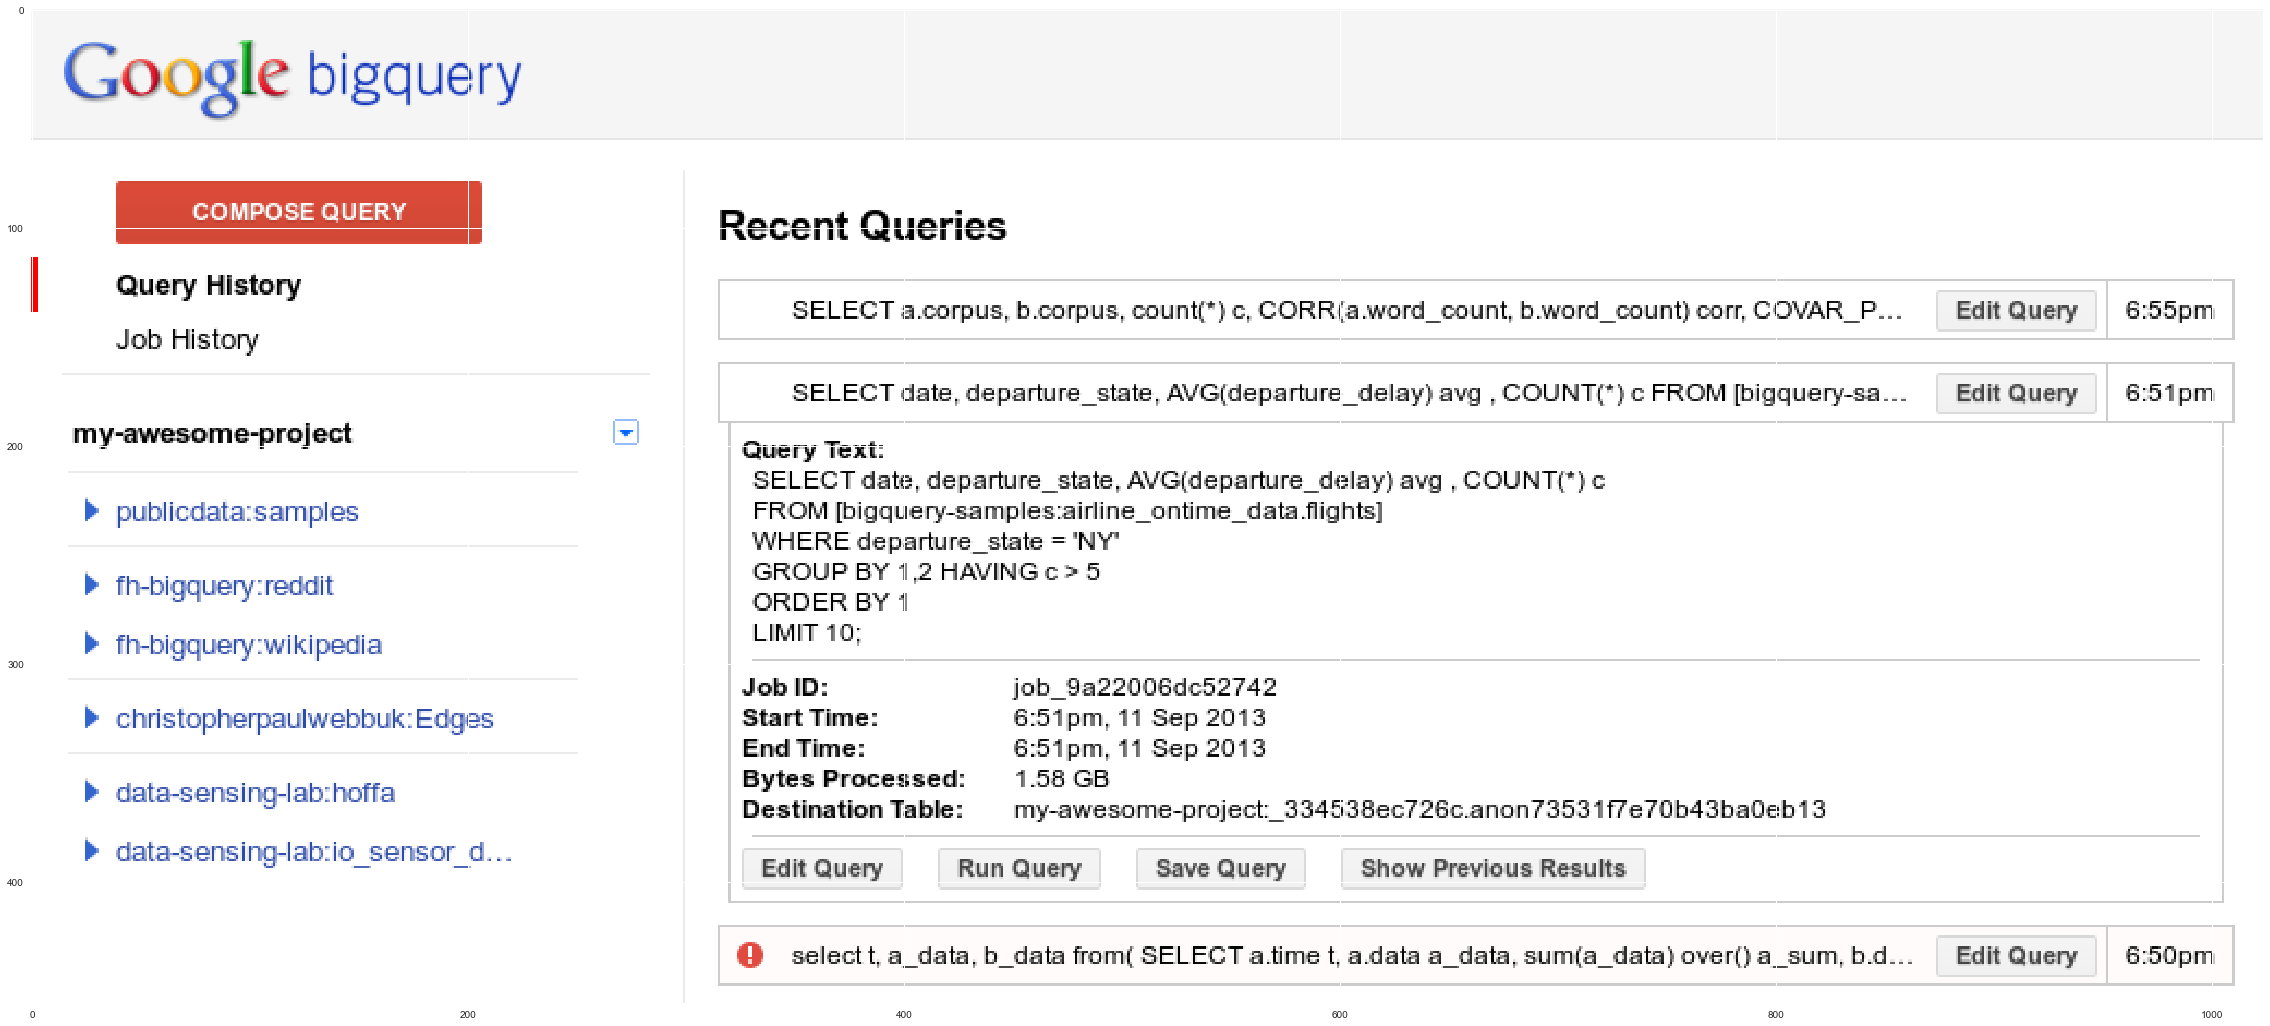

In [206]:
# create a file-like object from the url
sql_join_img = urllib.request.urlopen("http://2.bp.blogspot.com/-dBz24ax7ZOk/UjlB-h0-CkI/AAAAAAAAAIw/cENlCYoLb2E/s1600/bigquery-history.png")
a = plt.imread(sql_join_img, format='gif')
plt.figure(figsize=(40,30))
plt.imshow(a)
plt.show()

#  1. SQL  - Intro

* SQL stands for Structured Query Language
* SQL Statement:

    __SELECT__  * __FROM__ table_name;

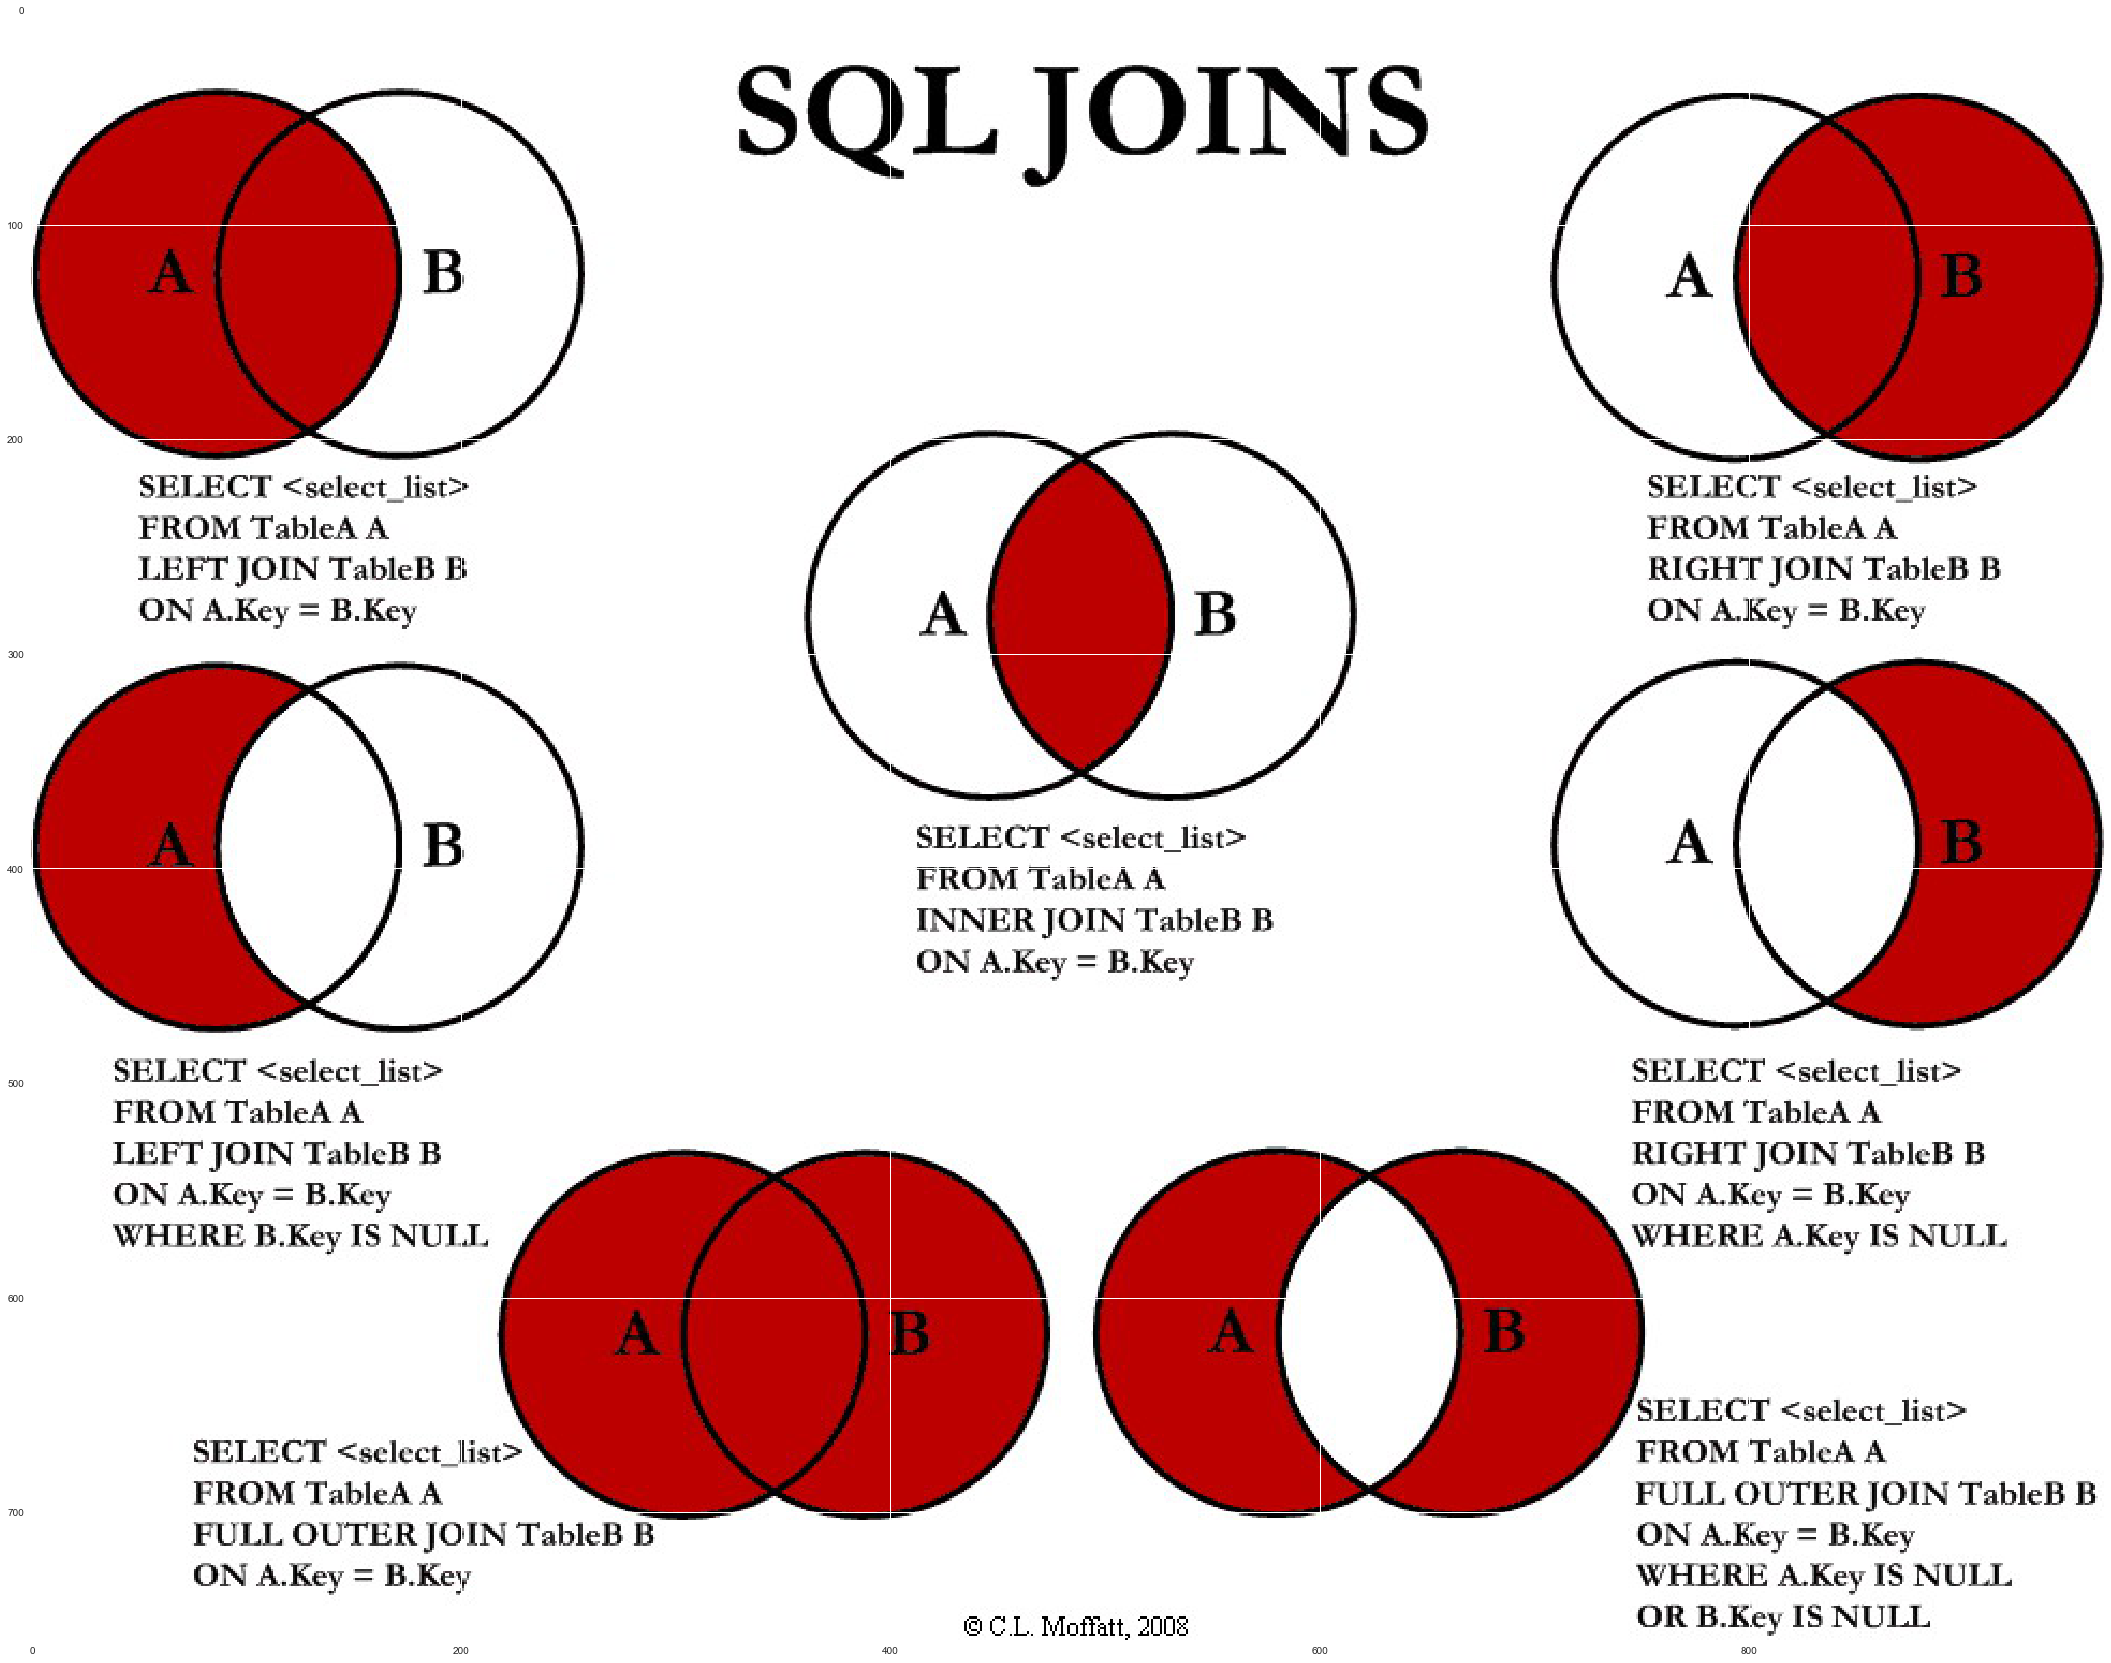

In [205]:
# create a file-like object from the url
sql_join_img = urllib.request.urlopen("https://i.stack.imgur.com/udQpD.jpg")
a = plt.imread(sql_join_img, format='gif')
plt.figure(figsize=(40,30))
plt.imshow(a)
plt.show()

In [175]:
query = '''
WITH delivery_location AS (
  SELECT
    lng.id AS order_id
    , decrypted_lat AS latitude
    , decrypted_lng AS longitude
  FROM `rgpkorea-datascience.dict.crypted_longitudes_20170100` lng
  LEFT OUTER JOIN `rgpkorea-datascience.dict.crypted_latitudes_20170100` lat ON lng.id = lat.id
)
, restaurant_location AS (
  SELECT
    res.id AS restaurant_id
    , res.name AS restaurant_name
    , add.lat AS latitude
    , add.lng AS longitude
  --   , dis.id AS district_id
  --   , dis.name AS district_name
    , city.name AS city_name
  FROM `rgpkorea-datalake.ods_yogyo.restaurant_restaurant` res
  LEFT OUTER JOIN `rgpkorea-datalake.ods_yogyo.restaurant_restaurantaddress` add on res.address_id = add.id
  LEFT OUTER JOIN `rgpkorea-datalake.ods_yogyo.geo_zipcode` zip on add.zip_code_id = zip.id
  -- LEFT OUTER JOIN `rgpkorea-datalake.ods_yogyo.geo_district_zipcodes` diszip on diszip.zipcode_id = zip.id
  -- LEFT OUTER JOIN `rgpkorea-datalake.ods_yogyo.geo_district` dis on dis.id = diszip.district_id
  LEFT OUTER JOIN `rgpkorea-datalake.ods_yogyo.geo_city` city on zip.city_id = city.id
  WHERE 1=1
    AND res.is_test_restaurant IS FALSE
    AND zip.code <> '000000'
    AND add.lat IS NOT NULL
    AND add.lat <> 0.0
)
-- , orders AS (
  SELECT
    cart_order.id AS order_id
    , cart_order.submitted_at
    , cart_order.restaurant_id
    , res.latitude AS lat_of_restaurant
    , res.longitude AS lng_of_restaurant
    , cart_order.district_id
    , del.latitude AS lat_of_delivery
    , del.longitude AS lng_of_delivery
    , dim_result.order_result
  FROM `rgpkorea-datalake.ods_yogyo.x_cart_order_by_submitted_201701*` cart_order
  LEFT OUTER JOIN `rgpkorea-datalake.dw3.dim_order_resultkey_details_status_ygy` dim_result on cart_order.result_key = dim_result.result_key
  LEFT OUTER JOIN `rgpkorea-datalake.ods_yogyo.restaurant_restaurant` dim_restaurant on cart_order.restaurant_id = dim_restaurant.id
  LEFT OUTER JOIN delivery_location del on cart_order.id = del.order_id
  INNER JOIN restaurant_location res ON cart_order.restaurant_id = res.restaurant_id
  WHERE 1=1
    AND cart_order._TABLE_SUFFIX BETWEEN '20' AND '21'
    AND dim_result.order_result = 'success'
    AND dim_restaurant.is_test_restaurant IS FALSE
    AND cart_order.created_in_mode!='phone'
    AND del.latitude IS NOT NULL  -- (25755/144560 = 17%)
    AND city_name LIKE '%서울%'
-- )
'''
project_id = 'rgpkorea-datascience'

In [176]:
df = pd.read_gbq(
                query=query
                , project_id=project_id
                , dialect='standard'
)

Requesting query... ok.
Job ID: job_Ql_i869DaSCfZvWqHA_KvvCY8Vbm
Query running...
  Elapsed 11.47 s. Waiting...
Query done.
Processed: 102.5 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 86% done. Elapsed 25.26 s.
  Got page: 2; 100% done. Elapsed 26.42 s.
Got 45000 rows.

Total time taken 27.41 s.
Finished at 2017-12-06 17:56:13.


In [177]:
df.head()

order_id               submitted_at  restaurant_id  lat_of_restaurant  \
0  85209102 2017-01-21 14:56:13.472563          57722          37.291669   
1  85122899 2017-01-20 21:52:32.589277         226232          37.619462   
2  85203995 2017-01-21 14:15:52.133397         226232          37.619462   
3  85323837 2017-01-21 21:33:12.733250         226232          37.619462   
4  85243381 2017-01-21 18:13:32.524514         226232          37.619462   

   lng_of_restaurant  district_id  lat_of_delivery  lng_of_delivery  \
0         127.145104         1930        37.292080       127.150747   
1         127.080185         5884        37.617206       127.080738   
2         127.080185         5884        37.617127       127.078391   
3         127.080185         1887        37.664430       127.069885   
4         127.080185         5884        37.608913       127.075733   

  order_result  
0      success  
1      success  
2      success  
3      success  
4      success

In [19]:
df_order_result.index.values

array([    0,     1,     2, ..., 55118, 55119, 55120], dtype=int64)

In [53]:
# 두 데이터프레임을 JOIN 해보기 (LEFT JOIN)
# pd.merge(df_a, df_b, on='subject_id', how='left')

key_df = pd.merge(df, df_order_result[['order_id','order_result']], on ='order_id', how='left')

In [56]:
df_order_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55121 entries, 0 to 55120
Data columns (total 9 columns):
order_id             55121 non-null int32
submitted_at         55121 non-null datetime64[ns]
restaurant_id        55121 non-null int32
lat_of_restaurant    55121 non-null float64
lng_of_restaurant    55121 non-null float64
district_id          55121 non-null int32
lat_of_delivery      55121 non-null float64
lng_of_delivery      55121 non-null float64
order_result         55121 non-null object
dtypes: datetime64[ns](1), float64(4), int32(3), object(1)
memory usage: 3.2+ MB


In [52]:
# 특정 ID의 값을 확인해보기
df_order_result.loc[df_order_result['order_id']==85087657]

order_id               submitted_at  restaurant_id  lat_of_restaurant  \
53985  85087657 2017-01-20 20:02:34.944196         232347          37.482264   

       lng_of_restaurant  district_id  lat_of_delivery  lng_of_delivery  \
53985         126.918352         2740        37.482207       126.907199   

      order_result  
53985      success

In [64]:
df_res_orders = df_order_result[['restaurant_id','lat_of_restaurant','lng_of_restaurant','order_id']].groupby(['restaurant_id','lat_of_restaurant','lng_of_restaurant'],).count()

In [78]:
# 데이터프레임에서 컬럼 이름 변경하기
#  df=df.rename(columns = {'two':'new_name'})
df2 = df_res_orders.rename(columns = {'order_id' : 'num_of_orders'})

# 인덱스를 컬럼으로 변경하기
df3 = df2.reset_index()

## 지도 위에 데이터 그려보기

In [22]:
# 지도 위에 데이터 그려보기
# https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

In [157]:
df3.describe()
# Seoul
# westlimit=126.799049; southlimit=37.450741; eastlimit=127.150269; northlimit=37.69917
# westlimit=126.584861; southlimit=36.958960; eastlimit=127.375407; northlimit=37.744569

restaurant_id  lat_of_restaurant  lng_of_restaurant  num_of_orders
count    6792.000000        6792.000000        6792.000000    6792.000000
mean   143469.820819          37.505966         127.005605       8.115577
std     99446.441395           0.142345           0.110185      11.647123
min        18.000000          36.958960         126.584861       1.000000
25%     39376.000000          37.489660         126.922335       2.000000
50%    217598.500000          37.538685         127.027203       4.000000
75%    236499.250000          37.588602         127.078484      10.000000
max    245812.000000          37.744569         127.375407     174.000000

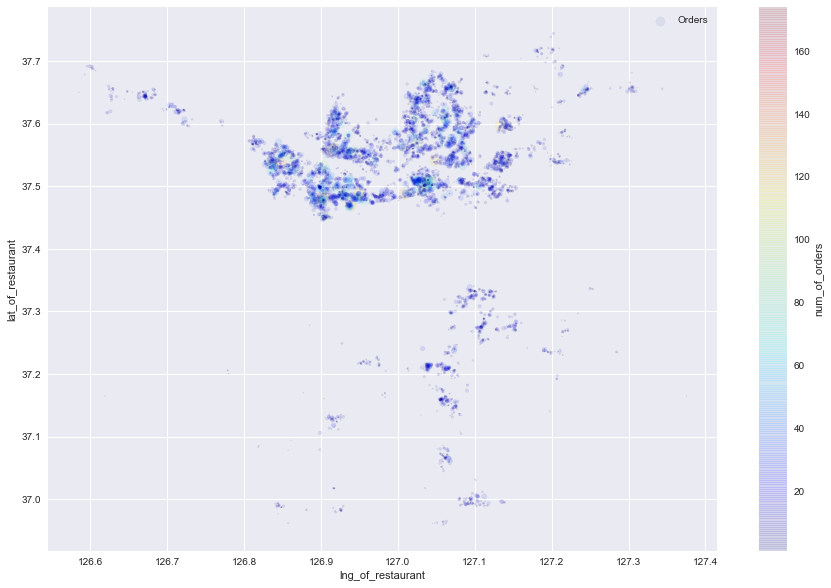

In [156]:
df3.plot(kind="scatter",
             x="lng_of_restaurant", y="lat_of_restaurant", alpha=0.1,
             figsize=(15,10),
             s=df3["num_of_orders"], label="Orders",              
             c="num_of_orders", cmap=plt.get_cmap("jet"), #colorbar=False,
             sharex=False
            )
plt.legend()
# save_fig("housing_prices_scatterplot")
plt.show()

In [91]:
# Seoul
# westlimit=126.799049; southlimit=37.450741; eastlimit=127.150269; northlimit=37.69917

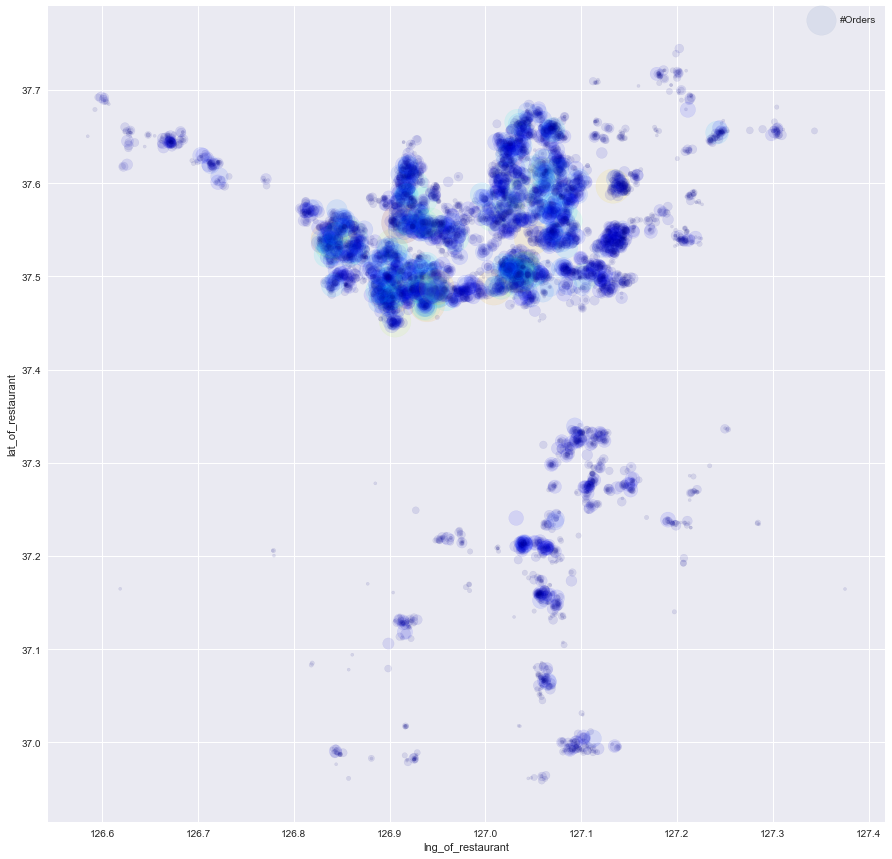

In [129]:
import matplotlib.image as mpimg

df3.plot(kind="scatter",
         x="lng_of_restaurant", y="lat_of_restaurant", alpha=0.1,
         figsize=(15,15),
         s=df3['num_of_orders']*10, label="#Orders",              
         c="num_of_orders", cmap=plt.get_cmap("jet"), colorbar=False,
         sharex=False
        )

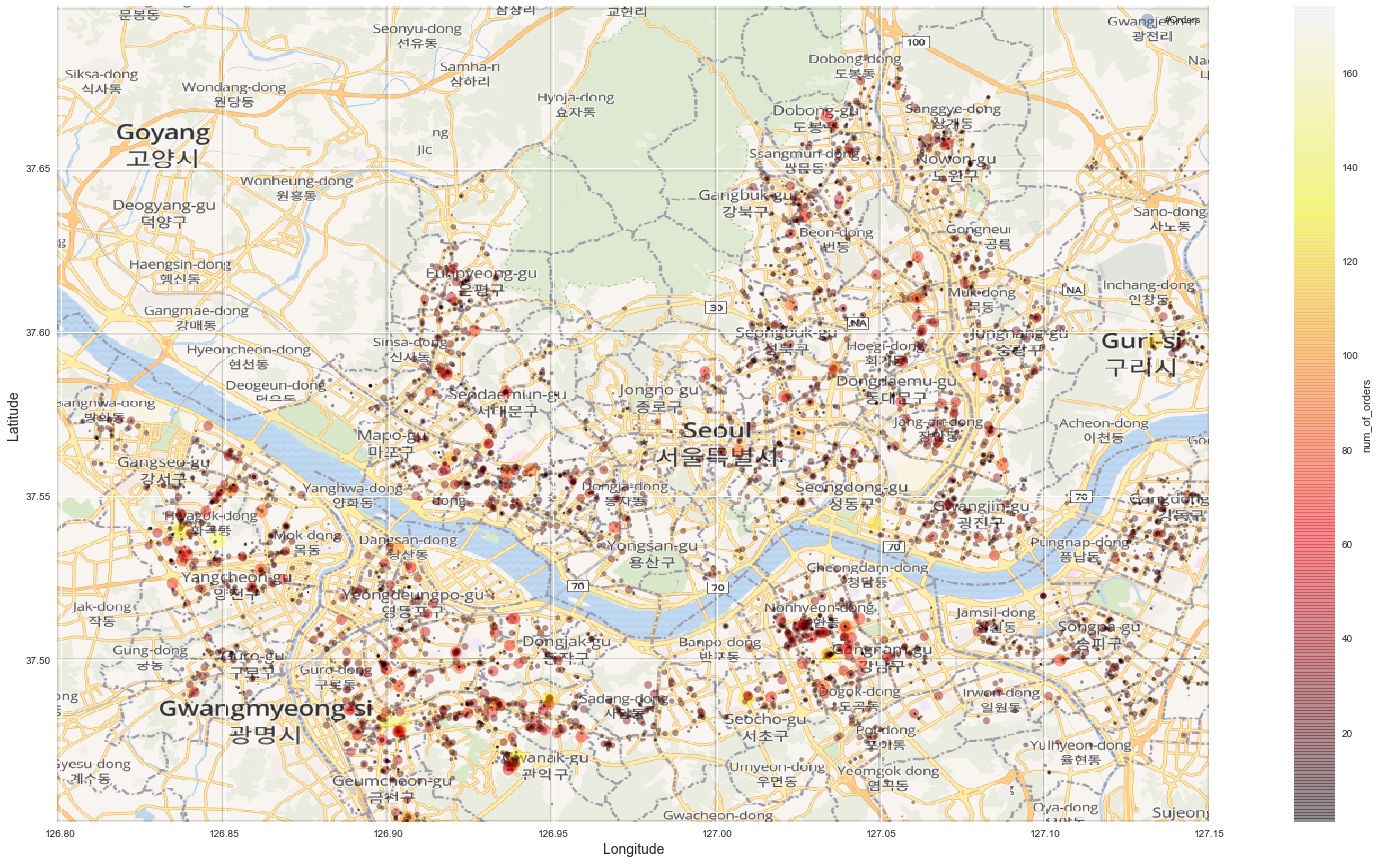

In [174]:
import matplotlib.image as mpimg

ax = df3.plot(kind="scatter"
        , x="lng_of_restaurant", y="lat_of_restaurant"
        , figsize=(30,15)
        , s=df3['num_of_orders']*2, label="#Orders"
        , c="num_of_orders", alpha=0.4
        # https://matplotlib.org/users/colormaps.html#diverging
        , cmap=plt.cm.hot # plt.get_cmap("jet"),  # plt.cm.RdYlGn
        , colorbar=True
        , sharex=False
        )
seoul_img=mpimg.imread('img/seoul.gif')

# seoul1: westlimit=126.799049; southlimit=37.450741; eastlimit=127.150269; northlimit=37.69917
# extent : scalars (left, right, bottom, top), optional, default: None
plt.imshow(seoul_img, extent=[126.799049, 127.150269, 37.450741, 37.69917])
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
# save_fig("california_housing_prices_plot")
plt.show()

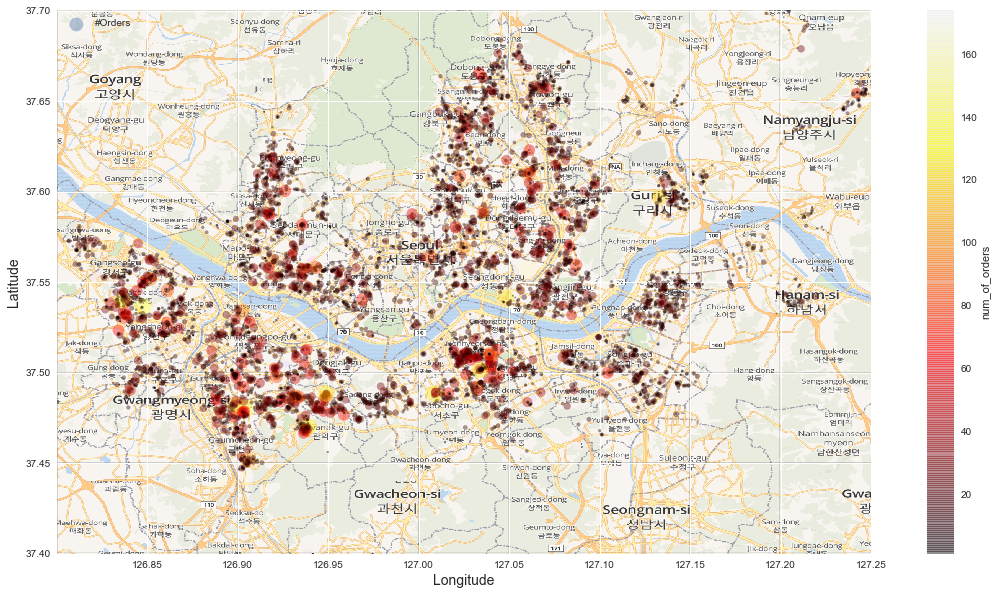

In [169]:
ax = df3.plot(kind="scatter"
        , x="lng_of_restaurant", y="lat_of_restaurant"
        , figsize=(20,10)
        , s=df3['num_of_orders']*2, label="#Orders"
        , c="num_of_orders", alpha=0.4
        # https://matplotlib.org/users/colormaps.html#diverging
        , cmap=plt.cm.hot # plt.get_cmap("jet"),  # plt.cm.RdYlGn
        , colorbar=True
        , sharex=False
        )

seoul2_img=mpimg.imread('img/seoul2.png')

# seoul1: westlimit=126.799049; southlimit=37.450741; eastlimit=127.150269; northlimit=37.69917
# extent : scalars (left, right, bottom, top), optional, default: None
plt.imshow(seoul2_img, extent=[126.800423, 127.249832, 37.399892, 37.700257])
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
# save_fig("california_housing_prices_plot")
plt.show()